In [1]:
%matplotlib notebook
import os,sys

!{sys.executable} -m pip install OpenVisus

import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import *

import OpenVisus as ov

ov.DbModule.attach()

PythonEngine is working fine


In [2]:
def readData(dataset,time=None,field=None,logic_box=ov.BoxNi(),resolution=None,thr=None):
    
    # setting default values if not provided
    if(time==None):
        time=dataset.getDefaultTime()
    if(field==None):
        field=dataset.getDefaultField()
    if(logic_box==ov.BoxNi()):
        logic_box=dataset.getLogicBox()
    if(resolution==None):
        resolution=dataset.getMaxResolution()
    
    # create an access mode (default "network") to access the data
    access=dataset.createAccess()
    # define a box query to fetch data from a certain dataset, field and timestep
    query=ov.BoxQuery(dataset, field, time,ord('r'))
    # set the bounding box for our query
    query.logic_box=logic_box
    # set the resolution 
    query.end_resolutions.push_back(resolution)
    # prepare and execute the query
    dataset.beginQuery(query)
    dataset.executeQuery(access,query)
    # transform the result of the query to a numpy array
    data=ov.Array.toNumPy(query.buffer,bSqueeze=True,bShareMem=False)
    
    if thr!=None:
        """
        Convert to grey_data
        If threshold is not None
        """
        R,G,B=(0.2989*data[:,:,0], 0.5870*data[:,:,1], 0.1140*data[:,:,2])
        grey_data=R+G+B
        return grey_data>thr
    
    return data

# function to plot the image data with matplotlib
# optional parameters: colormap, existing plot to reuse (for more interactivity)
def showData(data, cmap=None, plot=None):
    if(plot==None or cmap!=None):
        fig=plt.figure(figsize = (7,5))
        plot = plt.imshow(data, origin='lower', cmap=cmap)
        plt.show()
        return plot
    else:
        plot.set_data(data)
        plt.show()
        return plot

In [3]:
dataset=ov.LoadDataset("http://atlantis.sci.utah.edu/mod_visus?dataset=BlueMarble")

# Part1-1

<IPython.core.display.Javascript object>


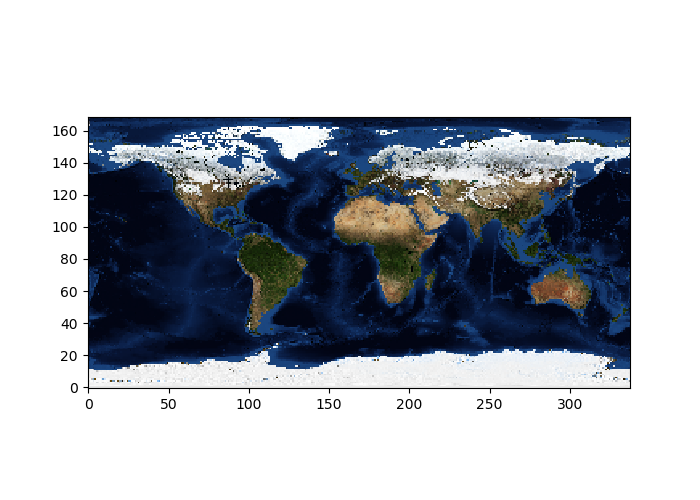

In [5]:
data = readData(dataset, time=0, resolution=17)
y,x,z = data.shape
plot1 = showData(data)
plt.savefig('HW2-1.png')

# Part1-2

<IPython.core.display.Javascript object>


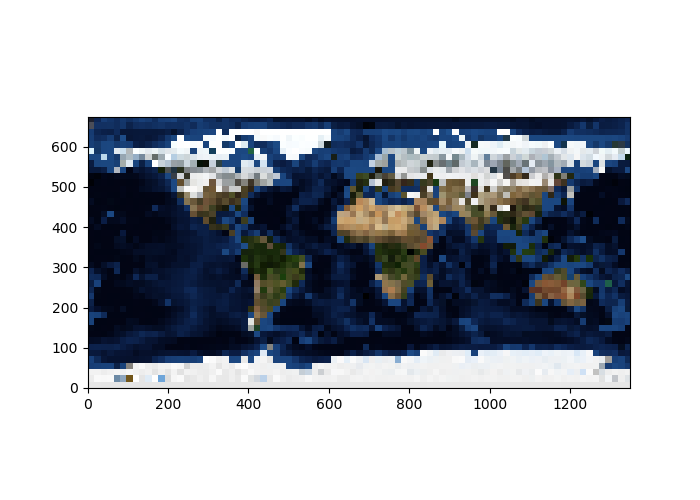

interactive(children=(IntSlider(value=9, description='resolution', max=21, min=5, step=4), Output()), _dom_cla…

In [34]:
myplot = showData(readData(dataset, time=0, resolution=21))

interact(
    lambda resolution: showData(readData(dataset,resolution=resolution), plot=myplot), 
    resolution=widgets.IntSlider(value=9,min=5,max=21,step=4))

plt.savefig('HW2-1-2.png')

# Part1-3

<IPython.core.display.Javascript object>


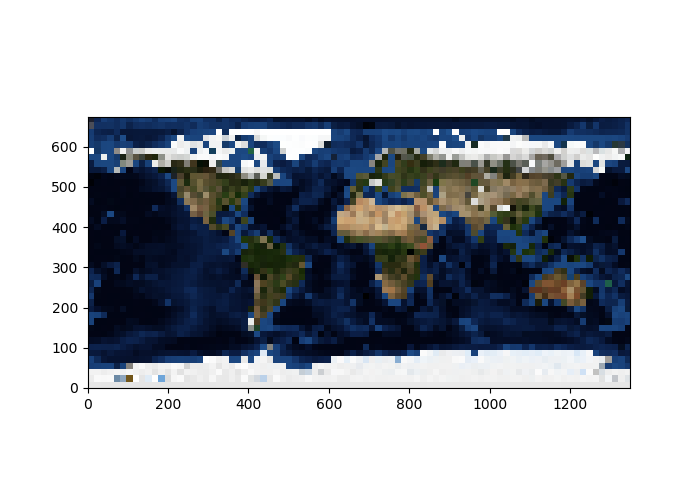

interactive(children=(IntSlider(value=0, description='time', max=11), IntSlider(value=9, description='resoluti…

<function __main__.<lambda>(time, resolution)>

In [8]:
myplot = showData(readData(dataset, time=0, resolution=21))

interact(
    lambda time,resolution: showData(readData(dataset,time=time,resolution=resolution), plot=myplot),
    time=widgets.IntSlider(value=0,min=0,max=11,step=1), 
    resolution=widgets.IntSlider(value=9,min=5,max=21,step=4))

# Part1-4

<IPython.core.display.Javascript object>


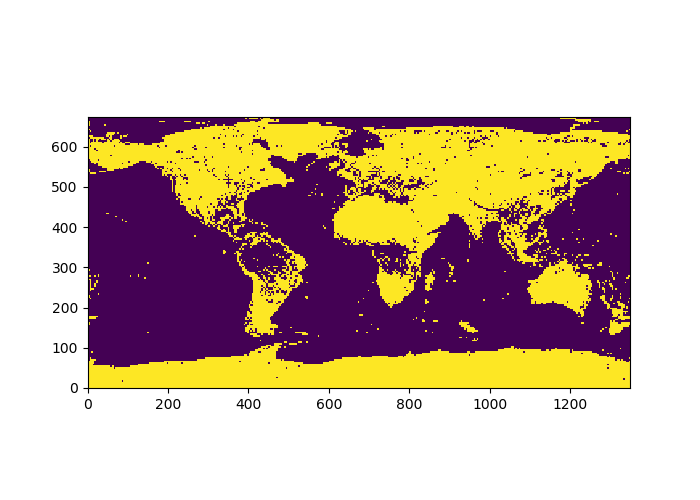

interactive(children=(IntSlider(value=0, description='time', max=11), IntSlider(value=17, description='resolut…

In [12]:
myplot=showData(readData(dataset, time=0, resolution=21,thr=250))
interact(
    lambda time,resolution,thr: showData(readData(dataset,time=time,resolution=resolution,thr=thr), plot=myplot),
    time=widgets.IntSlider(value=0,min=0,max=11,step=1), 
    resolution=widgets.IntSlider(value=17,min=5,max=21,step=4),
    thr=widgets.IntSlider(value=50,min=0,max=300,step=4))
plt.savefig('HW2-1-4.png')

# Part1-5-a

<IPython.core.display.Javascript object>


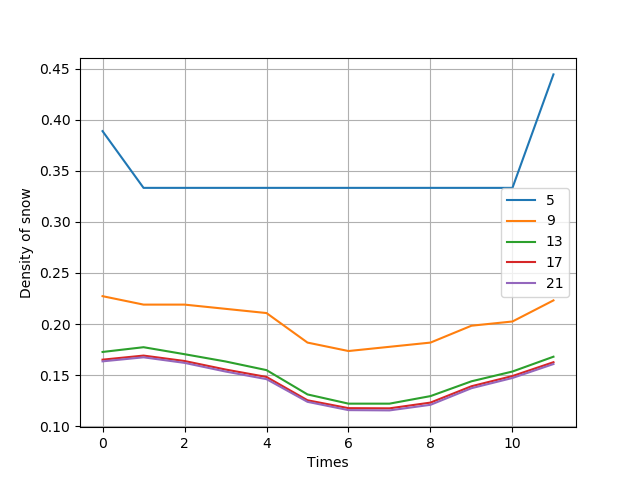

In [13]:
def density_sn(dataset,res,thr):
    dens = []
    for time in range(12):
        dt = readData(dataset, time=time, resolution=res)
        R,G,B=(0.2989*dt[:,:,0], 0.5870*dt[:,:,1], 0.1140*dt[:,:,2])
        dt=R+G+B
        count = (dt>thr).sum()
        x,y = dt.shape
        total = x*y
        dens.append(count/total)
    return dens

def plot_1_5():
    reses = [5,9,13,17,21] 
    times = [0,1,2,3,4,5,6,7,8,9,10,11]
    plt.figure()
    for res in reses:
        plt.plot(times,density_sn(dataset,res,210))
    plt.grid()
    plt.legend(reses)
    plt.xlabel("Times")
    plt.ylabel("Density of snow")
    
plot_1_5()
plt.savefig('HW2-1-5.png')

# Part1-5-b

<IPython.core.display.Javascript object>


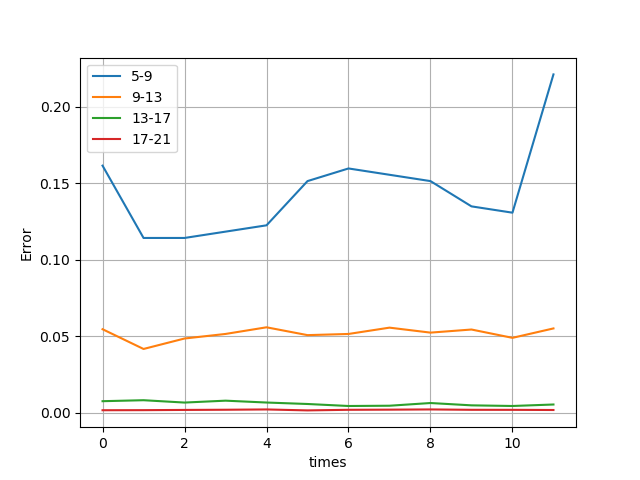

13-17 is less than 0.002 and std is 0.001310487734839918
17-21 is less than 0.002 and std is 0.0001843712523129319

Resolution 13 is in small standard deviation
Resolution 17 is in small standard deviation
Resolution 21 is in small standard deviation


In [15]:
def calcError(arr1,arr2):
    err = []
    for i,ele in enumerate(arr1):
        err_e = (ele-arr2[i])
        err.append(err_e)
    return err

def FindSmallStd():
    times = [0,1,2,3,4,5,6,7,8,9,10,11]
    reses = [5,9,13,17,21] 
    leg = []
    ans = set()
    plt.figure()
    for i in range(1,len(reses)):
        err = calcError(density_sn(dataset,reses[i-1],210),density_sn(dataset,reses[i],210))
        plt.plot(err)
        leg.append(str(reses[i-1])+"-"+str(reses[i]))
        std = np.std(err)
        if std<0.002:
            print("{0}-{1} is less than 0.002 and std is {2}".format(str(reses[i-1]),str(reses[i]),std))
            ans.add(reses[i-1])
            ans.add(reses[i])
    plt.grid()
    plt.legend(leg)
    plt.xlabel("times")
    plt.ylabel("Error")
    return ans
AnsSet = FindSmallStd()
AnsArr = sorted(list(AnsSet))
plt.savefig('HW2-1-5-b.png')
print("")
for ele in AnsArr:
    print("Resolution {} is in small standard deviation".format(ele))

# Part1-6

In [16]:
def density_Winter_NH(dataset,res,thr):
    dens = []
    times = [11,0,1,2]
    for time in times:
        dt = readData(dataset, time=time, resolution=res)
        R,G,B=(0.2989*dt[:,:,0], 0.5870*dt[:,:,1], 0.1140*dt[:,:,2])
        dt=R+G+B
        y,x = dt.shape
        NH = dt[y//2:,:]
        count = (NH>thr).sum()
        total = x*(y//2)
        dens.append(count/total)
    return dens


def findRange(dataset):
    from collections import defaultdict
    span = defaultdict(int)
    for res in AnsArr:
        total,cnt = 0,0
        for thr in range(194,280):
            dens = np.array(density_Winter_NH(dataset,res,thr))
            if all(dens==0) and all(dens<0.05):
                break
            if all(0.05<=dens) and all(dens<=0.15):
                total+=thr
                cnt+=1
        span[res] = total/cnt
    return span
            
totalRange = findRange(dataset)
print(totalRange)

defaultdict(<class 'int'>, {13: 225.0, 17: 218.5, 21: 218.0})


In [18]:
for res in totalRange:
    print("Optimal threshold at resolution {0} is {1}".format(res,totalRange[res]))

Optimal threshold at resolution 13 is 225.0
Optimal threshold at resolution 17 is 218.5
Optimal threshold at resolution 21 is 218.0


# Part1-7

In [25]:
def density_Inter(dataset,res,part=None,thr=None):
    thr = totalRange[res]
    dens = []
    for time in range(12):
        dt = readData(dataset, time=time, resolution=res)
        R,G,B=(0.2989*dt[:,:,0], 0.5870*dt[:,:,1], 0.1140*dt[:,:,2])
        dt=R+G+B
        y,x = dt.shape
        count = (dt>thr).sum()
        y,x = dt.shape
        total = y*x
        dens.append(count/total)
    Max,Min = max(dens),min(dens)
    print("Lowest month is {}".format(dens.index(Min)+1))
    print("Largest month is {}".format(dens.index(Max)+1))
    fig = plt.figure(figsize = (7,5))
    plot = plt.plot(dens)
    plt.xlabel("time")
    plt.ylabel("Snow density")
    plt.title("Resolution {0} at average threshold {1}".format(res,thr))
    plt.grid()
    plt.show()

In [26]:
interact(
    lambda res: density_Inter(dataset,res=res),
    res=widgets.IntSlider(value=13,min=13,max=21,step=4))
plt.savefig('HW2-1-7-21.png')

interactive(children=(IntSlider(value=13, description='res', max=21, min=13, step=4), Output()), _dom_classes=…

# Part1-8

In [27]:
def density_sn(dataset,res,thr,part):
    dens = []
    for time in range(12):
        data = readData(dataset, time=time, resolution=res)
        y,x,z = data.shape
        R,G,B=(0.2989*data[:,:,0], 0.5870*data[:,:,1], 0.1140*data[:,:,2])
        data=R+G+B
        if part==1:
            """
            Q1 section
            """
            data = data[y//2:,:x//2]
        if part==2:
            """
            Q2 section
            """
            data = data[y//2:,x//2:]
        count = (data>thr).sum()
        y,x = data.shape
        total = y*x
        dens.append(count/total)
    return dens

d1 = density_sn(dataset,21,totalRange[21],1)
d2 = density_sn(dataset,21,totalRange[21],2)

<IPython.core.display.Javascript object>


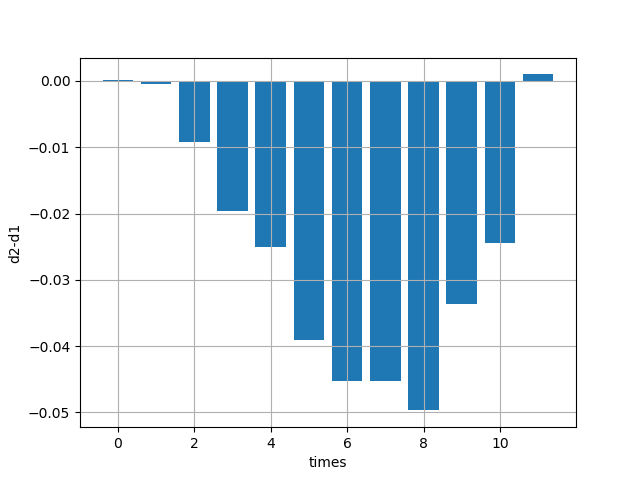

In [28]:
plt.figure()
diff = [d2[x]-d1[x] for x in range(len(d1))]
times = [0,1,2,3,4,5,6,7,8,9,10,11]
plt.bar(times,diff)
plt.grid()
plt.xlabel("times")
plt.ylabel("d2-d1")
plt.savefig('HW-1-8.png')

# Part1-8(Extra)

Because of efficiency, I use y-lable for name of each images. If I use title for each image, there are a lot of unused space. 

In [31]:
def Q1Q2_Inter(dataset,time):
    res,thr = 21, totalRange[21]
    dens = []
    data = readData(dataset, time=time, resolution=res)
    y,x,z = data.shape
    R,G,B=(0.2989*data[:,:,0], 0.5870*data[:,:,1], 0.1140*data[:,:,2])
    data=R+G+B
    Q1 = data[y//2:,:x//2]
    Q2 = data = data[y//2:,x//2:]
    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle("Q1 and Q2 snow part at {0} month".format(time+1))
    ax1.imshow(Q1>thr,origin='lower')
    ax1.set_ylabel("Q1")
    ax2.imshow(Q2>thr,origin='lower')
    ax2.set_ylabel("Q2")

In [33]:
interact(
    lambda time: Q1Q2_Inter(dataset,time=time),
    time=widgets.IntSlider(value=3,min=0,max=11,step=1))
plt.savefig('HW2-1-8-12.png')

interactive(children=(IntSlider(value=3, description='time', max=11), Output()), _dom_classes=('widget-interac…

# Part2-3

In [264]:
reses = [5,9,13,17,21]
totalT = 0
for res in reses:
    Q3d = readData(dataset, time=9, resolution=res)
    print("At resolution {0} memory usage is {1}".format(res,Q3d.nbytes))


At resolution 5 memory usage is 54
At resolution 9 memory usage is 726
At resolution 13 memory usage is 10965
At resolution 17 memory usage is 171366
At resolution 21 memory usage is 2733750


# Part2-5

In [268]:
from collections import defaultdict
meme = defaultdict(int)
for res in reses:
    cur = 0
    for time in range(12):
        Q3d = readData(dataset, time=time, resolution=res)
        meme[res] += Q3d.nbytes
        
for res in meme:
    print("At resolution {0} memory usage is {1}".format(res,meme[res]))


At resolution 5 memory usage is 648
At resolution 9 memory usage is 8712
At resolution 13 memory usage is 131580
At resolution 17 memory usage is 2056392
At resolution 21 memory usage is 32805000
